## Time Series

<ul>
    <li>A time series is a sequence set of data points, measured typically over successive times</li>
    <li>It is mathematically defined as a set of vecotrs x(t), t=0,1,2,... where t represents the time elapsed</li>
    <li>The variable x(t) is treated as a random variable</li>
    <li>The measurement taken during an event in a time series are arranged in a proper chronological order</li>
    <li>A time series containing records of a single variable is termed as univariante and more than one variable a multivariant</li>
</ul>

## Business use cases of time series forcasting

<ul>
    <li>Sales forcast - retail products sales forcast</li>
    <li>Demand forcasting - uses in pricing, inventory and workforce management</li>
    <li>Traffic forecast - transport and route optimization, road facility design</li>
    <li>Revenue forcast - budgeting, target setting</li>
</ul>

## Importing Libraries for time series forcasting

In [2]:
import warnings 
import itertools
import numpy as numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error


## Importing Data

<ul>
    <li>Dataset: International airline passenger</li>
    <li>Unit: Thousands</li>
</ul>

In [3]:
df = pd.read_csv('data/international-airline-passengers.csv')

In [4]:
df.shape

(144, 2)

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df.rename(columns = {'Month': 'year', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'passengers'}, inplace = True)

In [7]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [8]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df.describe(include='O')

,year
count,144
unique,144
top,1960-10
freq,1


## Data Preprocessing and Visualization

#### Converting to datetime format

In [10]:
df['year'] = pd.to_datetime(df['year'], format = '%Y-%m')

#### Setting index as the datetime column for easier manipulations:

In [11]:
y = df.set_index('year')

In [12]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [13]:
y.isnull().sum()

passengers    0
dtype: int64

<AxesSubplot:xlabel='year'>

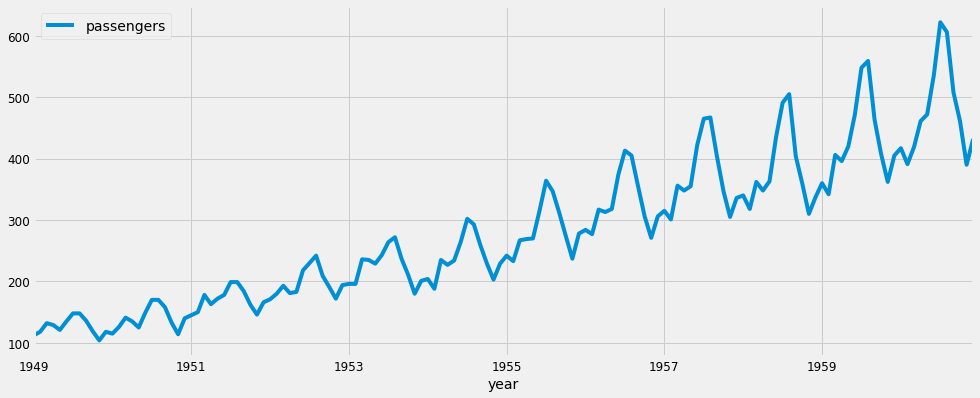

In [14]:
y.plot(figsize=(15, 6))

#### Reviewing plots of the density of observations can provide future insight intothe structure of the data:

<ul>
    <li>The distribution is not perfectly Gaussian (normal distribution)</li>
    <li>The distribution is left shifted</li>
    <li>Transformation might be usefull prior to modeling</li>
</ul>

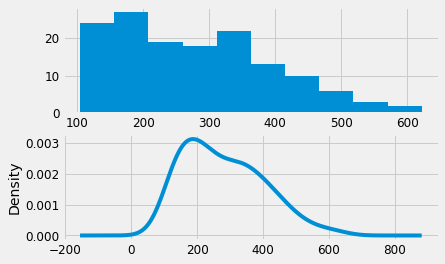

In [15]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

#### Box and Whisker Plots:

<ul>
<li>Median value across year confirms an upwards trend</li>
<li>Stedy increases in the spread or middle 50% of the data (boxes) over time</li>
<li>A model considering seasonality might work well</li>
</ul>

<AxesSubplot:xlabel='year', ylabel='passengers'>

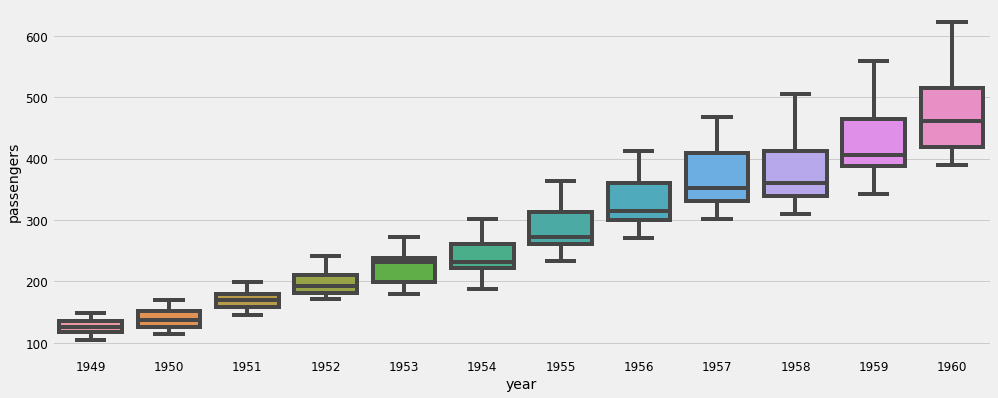

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

### Decomposing using stats model:

<ul>
<li>We can use stats model to perform a decomposition of this time series</li>
<li>The decomposing of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns</li>
<li>With stats models we will be able to see the trends seasonal, and residual components of out data. </li>
</ul>

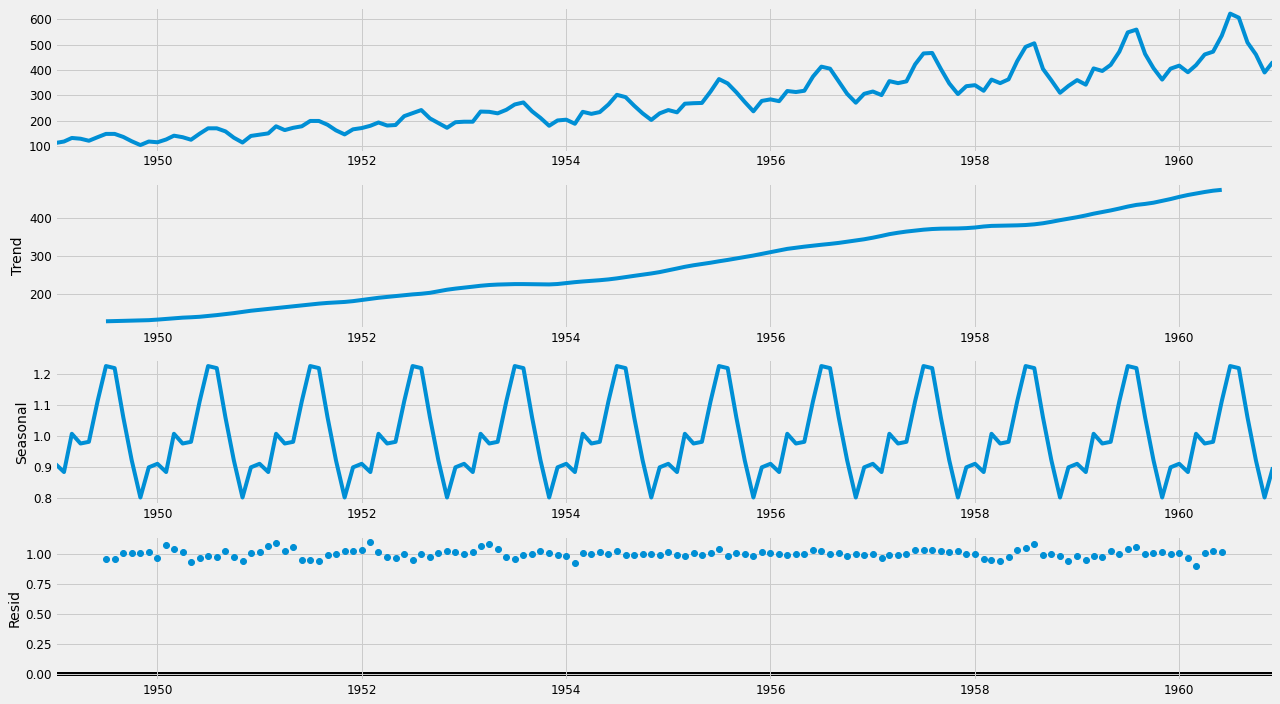

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Stationarity
<ul>
    <li>A Time Series is said to be stationary if its stastical properties sush as mean, variance remain constant over time.</li>
    <li>Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but one way for stationary.</li>
    <li>Intutively we can say that if a Time Series has a particular behavour over time there is a very high probablity that it will follow the same in the future
    <li>Also the theories related ti stationary series are more mature and easier to implement as compared to non-stationary series.</li>
<ul>    

<AxesSubplot:xlabel='year'>

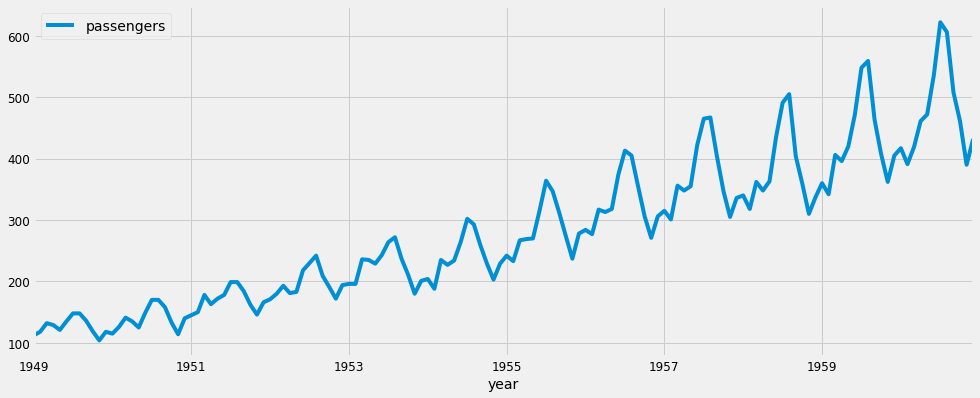

In [18]:
y.plot(figsize=(15, 6))

### We can check stationary using the followin:
<ul>
    <li><b>ACF and PACF plots</b>:If the TS is stationary, the ACF/PACF plots will show a <b>quick drop-off in correlation</b> after a small amount of lag between points</li>
    <li><b>Plotting Rolling Statistics:</b>We can plot the moving average or moving variance ans see if it varies with time. Moving average/variance is for any instant 't', the average/variance of the last year. i.e last 12 months</li>
    <li><b>Augmented Dickey-Fuller Test</b>: This is one of the stastical tests for checking stationary. here the null hypothesis is that the TS is non-stationary. The test results comprise of a test Statistics ans some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary. Refer the article for details</li>
</ul>

### ACF and PACF plots

<ul>
    <li>let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PCAF) plots</li>
    <li>If the time series is stationary, the ACF/PACF plots will show a <b>quick drop-off in correlation</b> after a small amount of lag between points</li>
    <li>This data is non-stationary as high number of previous observation are correlated with future values.</li>
    <li>Confidence intervals are drown as a cone</li>
    <li>By default, this is et to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statisical fluke.</li>
    <li>The partial autocorrelation atlag k is the correation that results after removing the effect of any correlation due to the terms at shorter lags</li>
</ul>

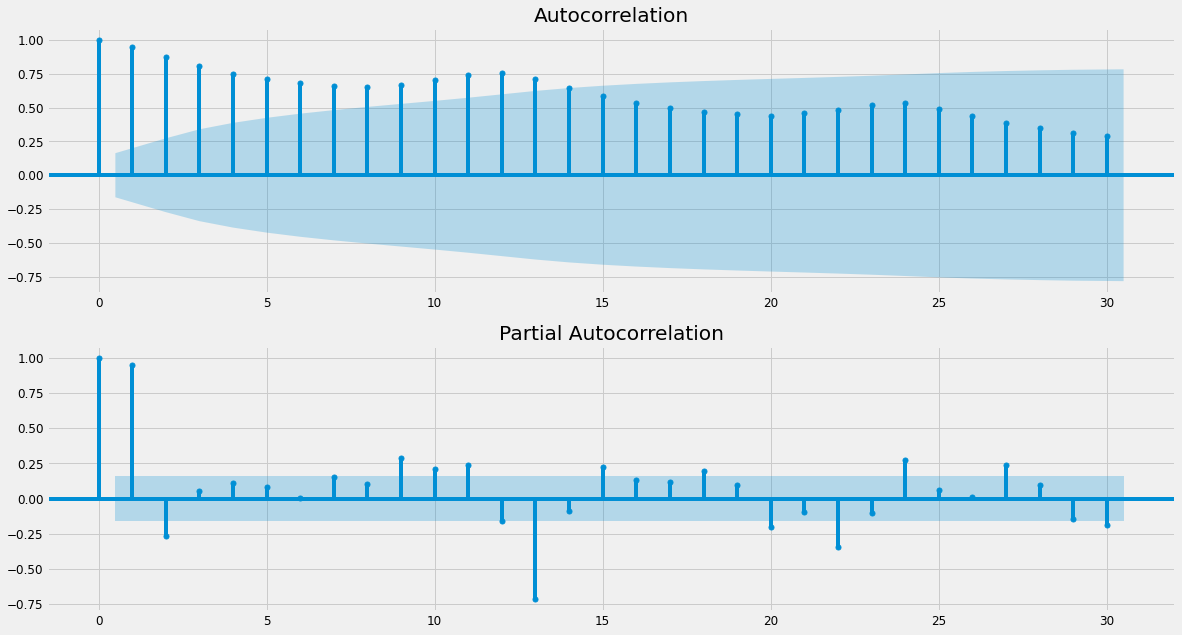

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics

<ul>
    <li>We observed that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)</li>
    <li>The time series is hence not stationary</li>
<ul>

In [20]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


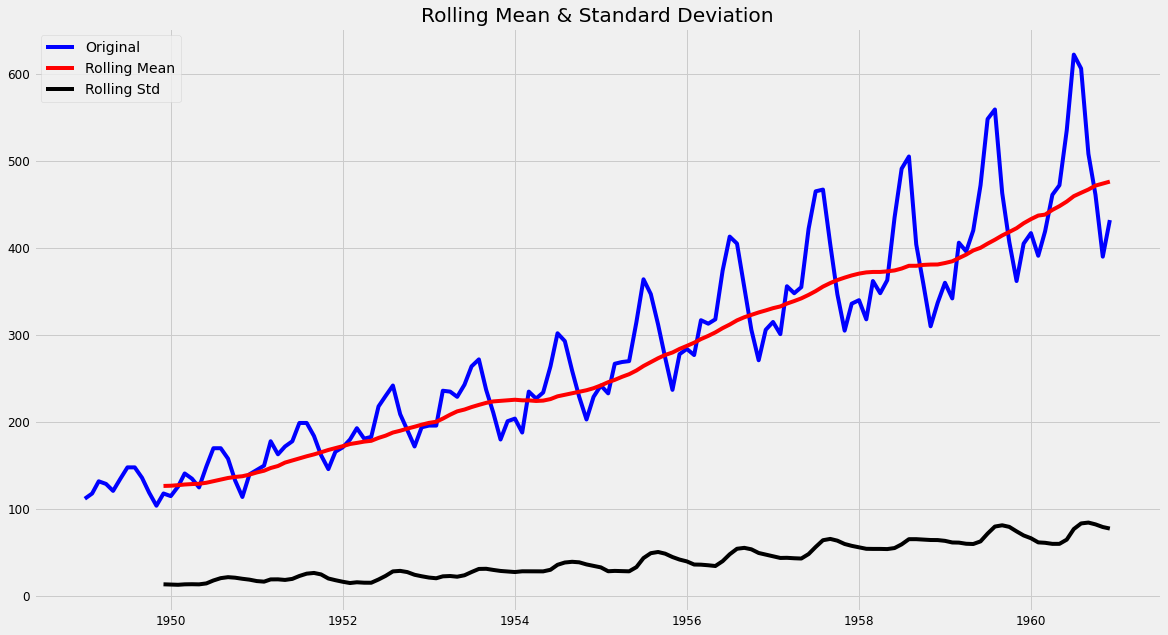

In [21]:
# Determining rolling statistics 
rolmean = y.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = y.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [22]:
# As you see the rolling Mean is not constant as it is increasing

### Augmented Dickey-Fuller Test

<ul>
    <li>The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predecting the change in y(t)</li>
    <li>Null hypothesis: the time series is not stationary</li>
    <li>Accept the null hypothesis (i.e a very low p-value) will indicate stationary</li>
</ul>

In [23]:
# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

Results of Dickey Fuller Test
Test Statistic             0.815369
p-value                    0.991880
#Lags Used                13.000000
Number of Observation    130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


## Making Time Series Stationary

<p>There are 2 major reasons behind non-stationary of a TS:</p>
<ol>
    <li><b>Trend</b> - varying mean over time For e.g in This case we saw that on average, the number of passenger was growing over time</li>
    <li><b>Seasonality</b> - variations at specific time-frame. eg people might have a tendency to buy cars in a particular month beacuse of pay increment or festivals</li>
</ol>

## Transformations
<ul>
    <li>We can apply transformation which prnalize higher values more than smaller values. These can be taking a log, square root, cube root, etc Lets take a log Transformation here for simplicity</li>
</ul>

### LogScale Transformation 

In [24]:
import numpy as np

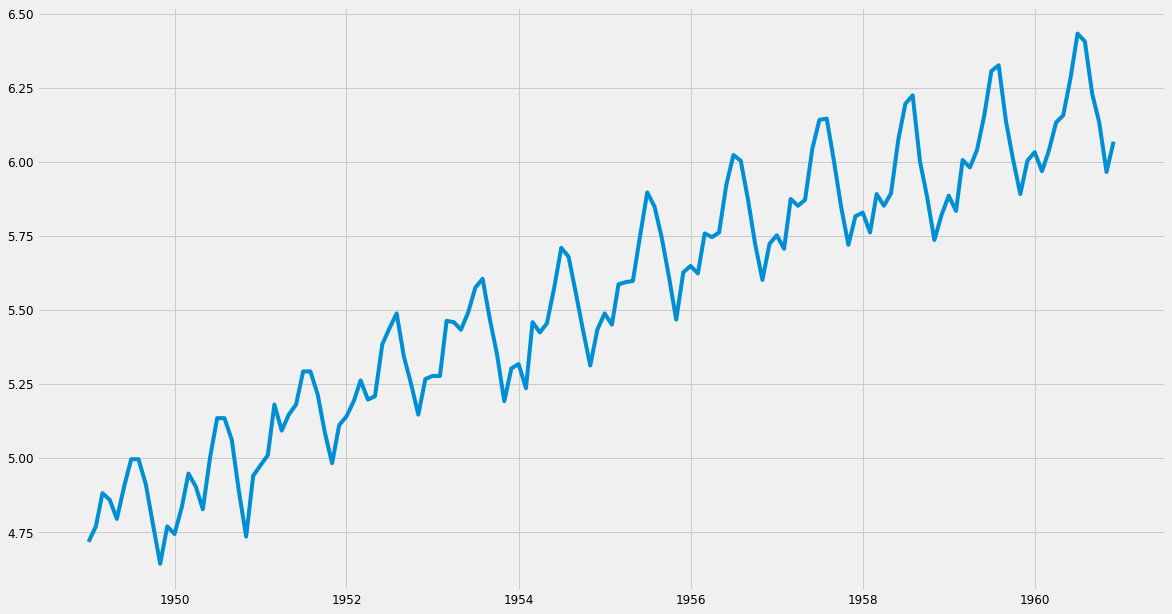

In [25]:
ts_log = np.log(y)
plt.plot(ts_log)

### Other possible transformation
<ul>
    <li>Exponential trnasform</li>
    <li>Box Cox transform</li>
    <li>Square root trnasformation</li>
</ul>

### Techniques to remove Trend - Smoothing
<ul>
    <li>Smoothing is taking rolling averages over windows of time</li>
</ul>    

### Movinf average
<ul>
    <li>we take average of 'k' consecutive values depending on the frequency of time sereis </li>
    <li>Here we can take the average over the past 1 year i.e last 12 (months)values</li>
    <li>A drawbackin this particular approach is that the time-period has to be strictly defined</li>
</ul>

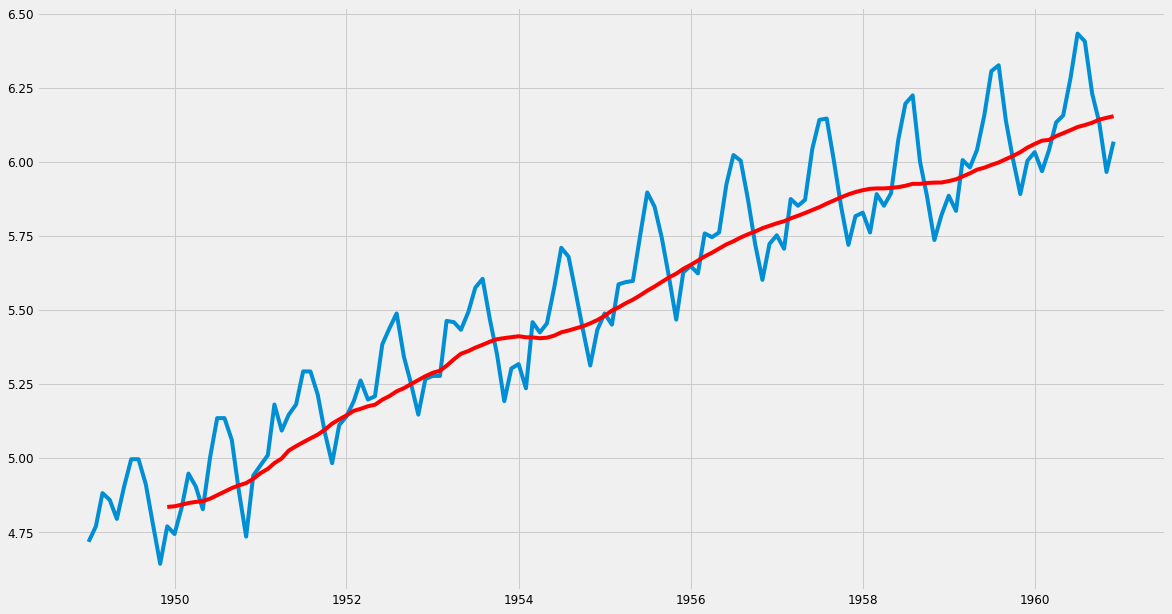

In [26]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [27]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

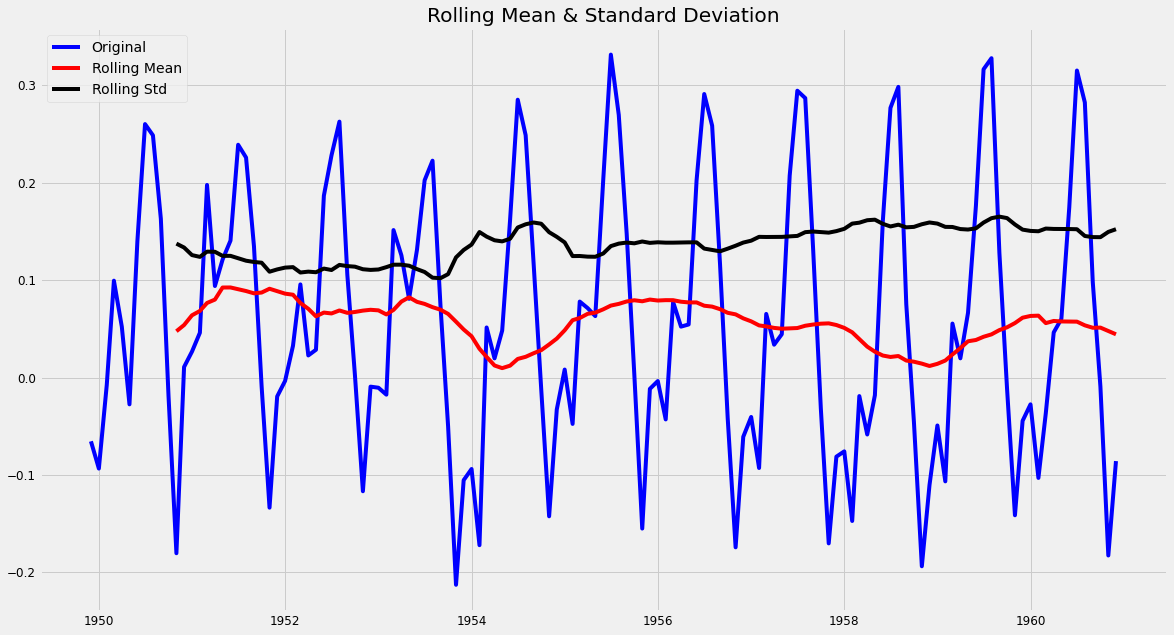

Results of Dickey Fuller Test
Test Statistic            -3.162908
p-value                    0.022235
#Lags Used                13.000000
Number of Observation    119.000000
Critical Value (1%)       -3.486535
Critical Value (5%)       -2.886151
Critical Value (10%)      -2.579896
dtype: float64


In [28]:
ts_log_moving_avg_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_moving_avg_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_moving_avg_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_moving_avg_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

In [29]:
ts_log_moving_avg_diff.head()

year
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: passengers, dtype: float64

### Exponentially weighted moving average: (exponential smoothining)
<ul>
    <li>To over come the problem of choosing a defined window in the moving average, we can use exponential weighted moving average</li>
    <li>We take a 'weighted moving average' where more recent values are given a higher weight.</li>
    <li>There can be many technique for assigning weights. Apopular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor</li>
</ul>    

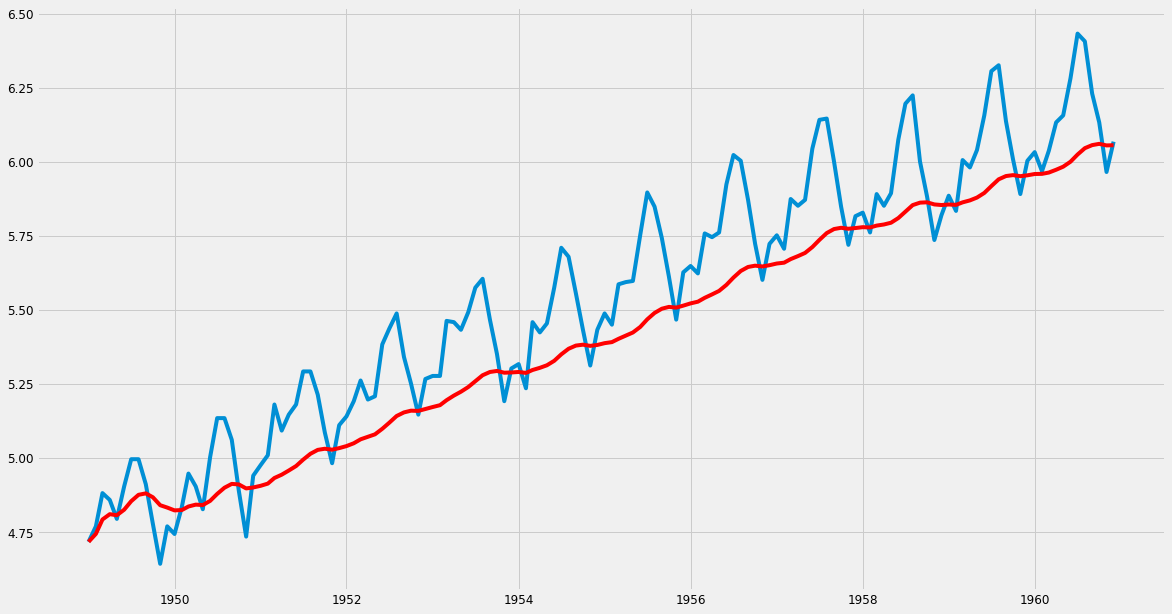

In [30]:
expwighted_avg =  ts_log.ewm(halflife=12).mean()
# pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

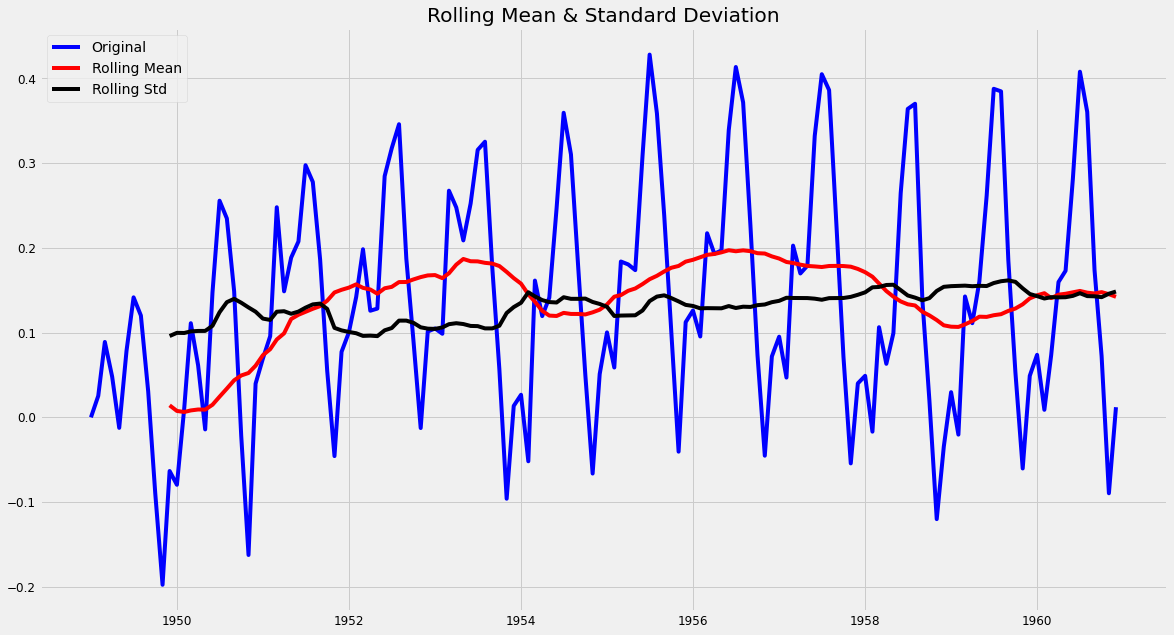

Results of Dickey Fuller Test
Test Statistic            -3.601262
p-value                    0.005737
#Lags Used                13.000000
Number of Observation    130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


In [31]:
ts_log_ewma_diff = ts_log - expwighted_avg

ts_log_ewma_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_ewma_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_ewma_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_ewma_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_ewma_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

### Future Techniques to remove Seasonality and Trend
<ul>
    <li>The simple trend reduction techniques discussed before dont work in all cases, particularly the ones with high seasonality</li>
<!--     <li></li> -->
</ul>

### Differencing
<ul>
    <li>In this technique, we take the difference of the observation at a particular instant with that at the previous instant</li>
    <li>First oreder differencing in Pandas</li>
</ul>

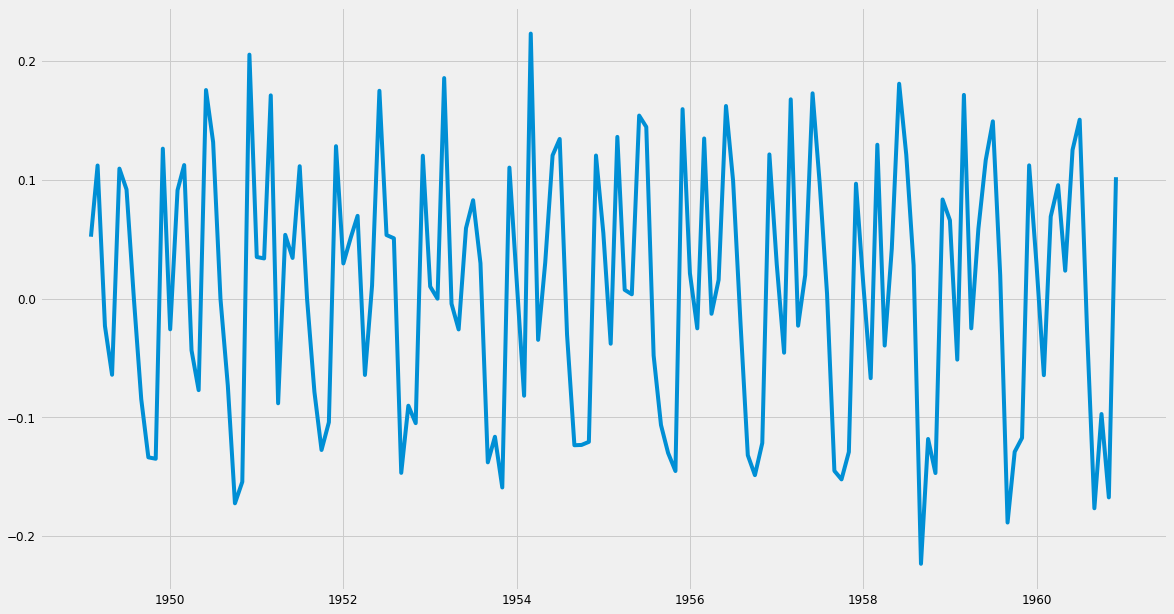

In [32]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

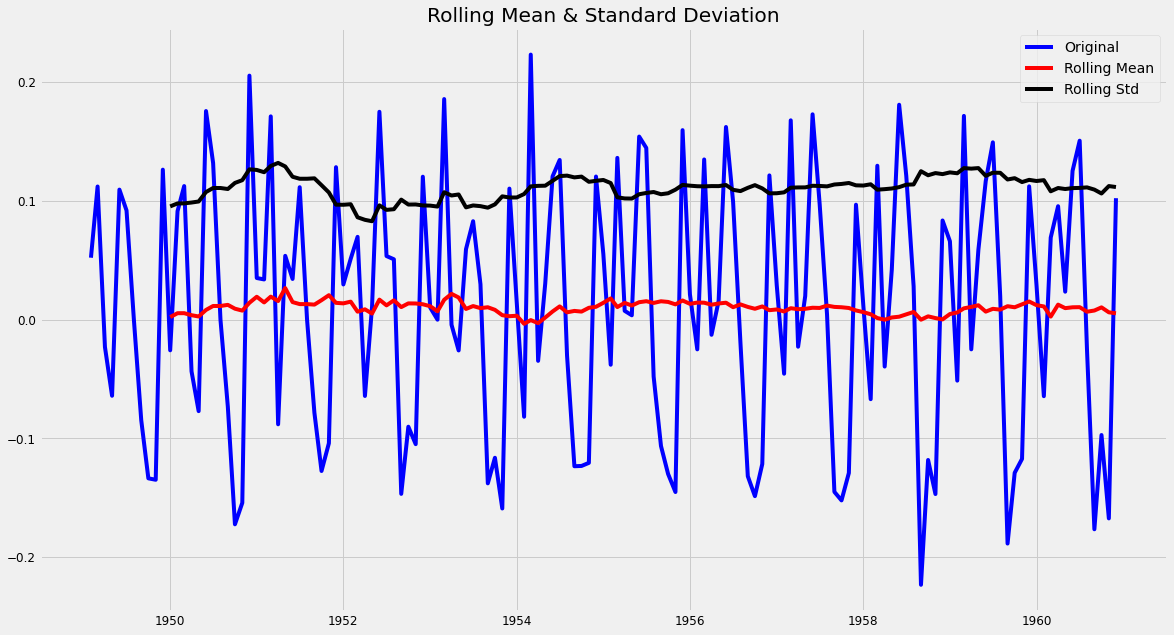

Results of Dickey Fuller Test
Test Statistic            -2.717131
p-value                    0.071121
#Lags Used                14.000000
Number of Observation    128.000000
Critical Value (1%)       -3.482501
Critical Value (5%)       -2.884398
Critical Value (10%)      -2.578960
dtype: float64


In [33]:
ts_log_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)   

### Decomposition 
<ul>
    <li>IN this approach, both trend and seasonality are modeled seoerately and the remaining part of the series is returned</li>
</ul>

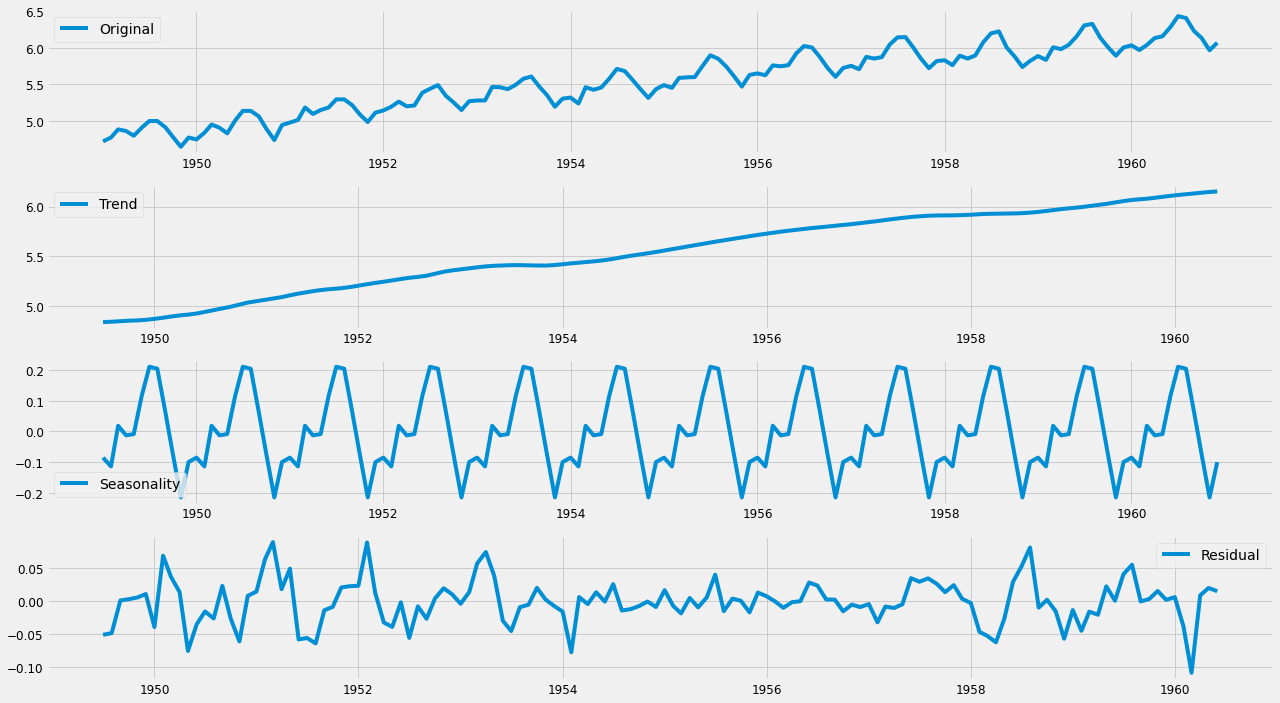

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
## it is to show even after the transformation actual data is preserved

In [36]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

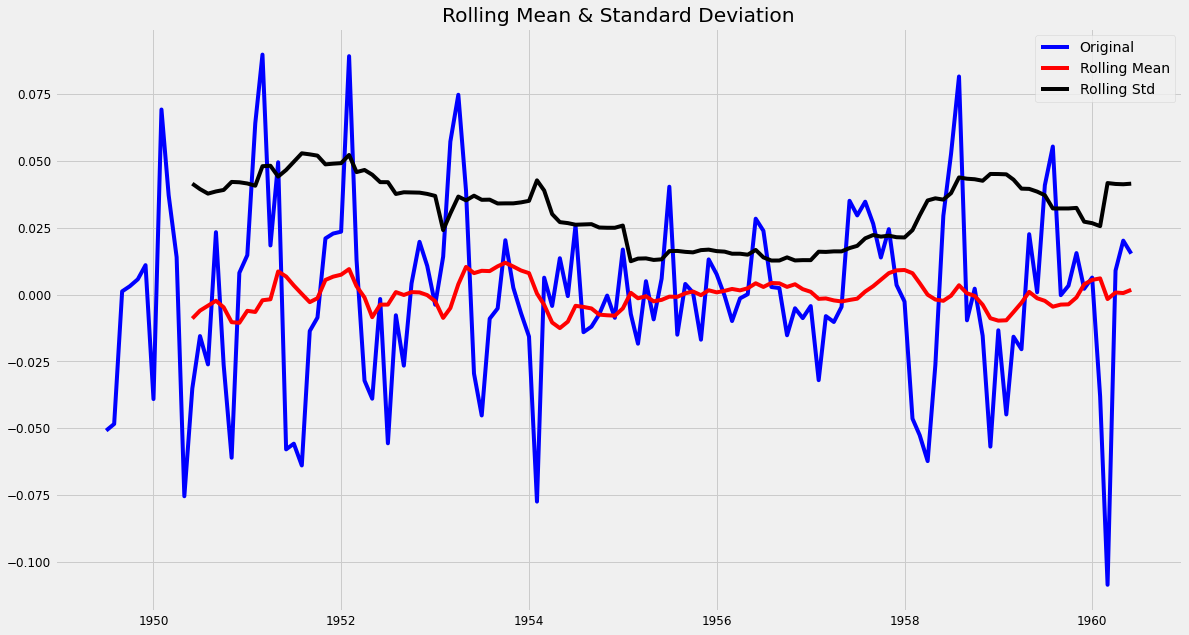

Results of Dickey Fuller Test
Test Statistic          -6.332387e+00
p-value                  2.885059e-08
#Lags Used               9.000000e+00
Number of Observation    1.220000e+02
Critical Value (1%)     -3.485122e+00
Critical Value (5%)     -2.885538e+00
Critical Value (10%)    -2.579569e+00
dtype: float64


In [37]:
rolmean = ts_log_decompose.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_decompose.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_decompose, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_decompose, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)  

## Time Series forcasting

### Autoregression (AR)

<ul>
    <li>The autoregression (AR) method the next step in the sequence as a linear function of the observations at prior timesteps</li>
    <li><b>Number of AR (Auto-Regressive) terms (p)</b>:p is the parameter associated with auto-regressive aspect of the model which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)...x(t-5).</li>
</ul>

In [38]:
from statsmodels.tsa.ar_model import AR
from random import random

In [39]:
model = AR(ts_log_diff) # series has to be stationary as a result 
model_fit = model.fit()

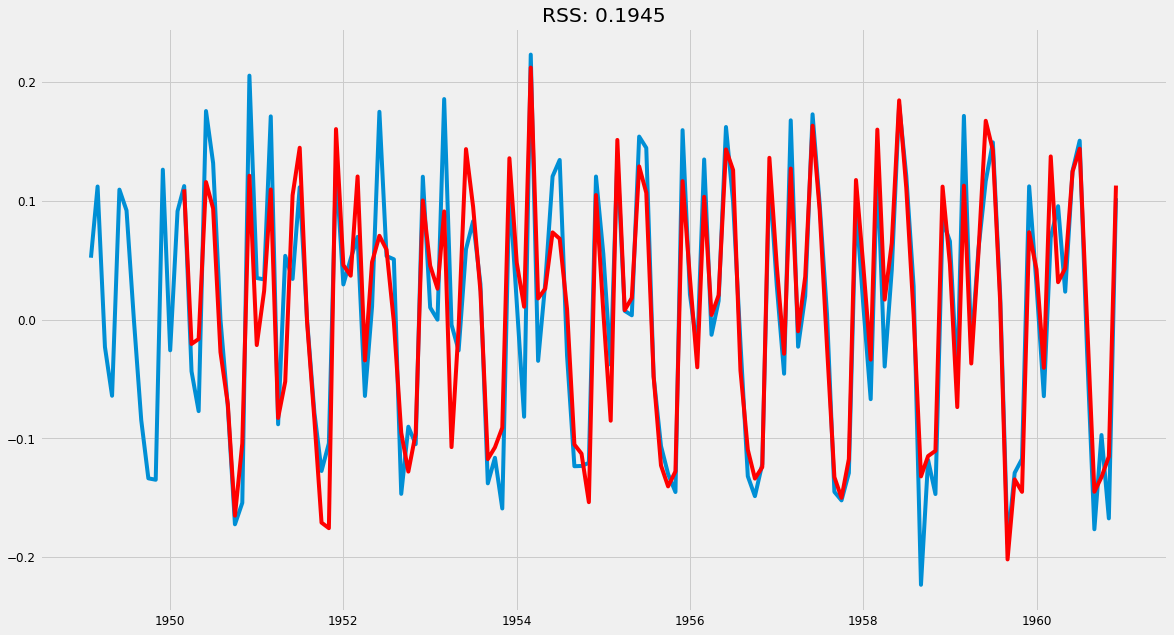

In [40]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()
# red coloured is the predected one 
# blue is the orginal one

In [41]:
# to check the model is predected well we use RMSE 

### Reversing the Transformation 

#### Fitted or Predicted values

In [42]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


#### Cumulative Sum to reverse differencing

In [43]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


#### Adding 1st month value which was previously removed while differencing:

In [44]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

### Taking Exponent to reverse Log Transform:

In [45]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.514374')

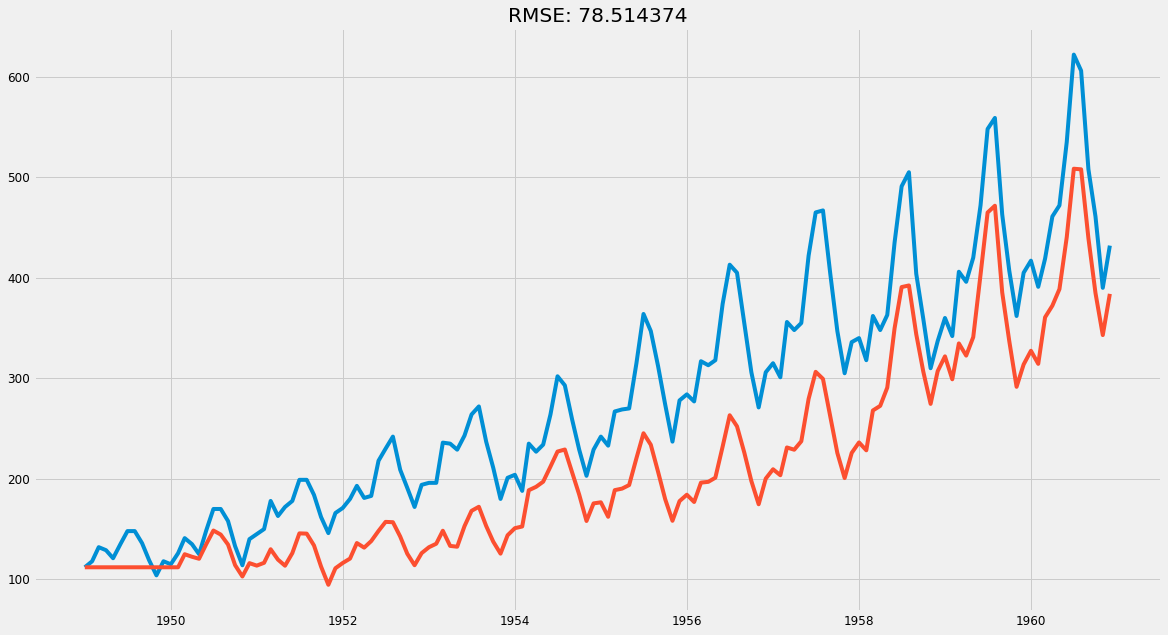

In [46]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %4f'%np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

In [47]:
# as you see in the AR model predection is in right direction but there is lot of difference

### Forecast quality scoring metrics

<ul>
    <li>R squared</li>
    <li>Mean Absolute Error</li>
    <li>Mean Absolute Error</li>
    <li>Mean Squared Error</li>
    <li>Mean Squared Logrithmic Error</li>
    <li>Mean Absolute Percentage Error</li>
</ul>

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

<p><b>R squared</b>, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf,1]</p>
<ul>
<li>sklearn.metrics.r2_score</li>
</ul>

In [49]:
r2_score(y.passengers, predictions_ARIMA)

0.5686734896130747

<b>Mean Absolute Error</b> it is an interpretable metricbecause it has the same unit of measurement as the initial series [0,+inf)
<ul>
    <li>sklearn.metrics.mean_absolute_error</li>
</ul>    

In [50]:
mean_absolute_error(y.passengers, predictions_ARIMA)

69.42862838872742

<p><b>Mean Squared Error,</b> most commonly used, gives higher penalty to big mistakes and vise versa [0,+inf)</p>
<ul>
    <li>sklearn.metrics.mean_squared_error</li>
</ul>    

In [51]:
mean_squared_error(y.passengers, predictions_ARIMA)

6164.506983577624

<p><b>Mean Squared Logarithmic Error</b> pratically the same as MSE but initially take logarithm of the series as a result we give attention to spell mistake as well, usually is used when data has exponential trends [0,+inf)</p>
<ul>
    <li>sklearn.metrics.mean_squared_error</li>
</ul>

In [52]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.09945599448249746

<p><b>Mean Absolute Percentage Error</b>: same as MAE ... </p>

In [53]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def evaluate_forcast(y, pred):
    results                          = pd.DataFrame({'r2_score':r2_score(y, pred)},index=[0])
    results['mean_absolute_error']   = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse']                   = mean_squared_error(y, pred)
    results['msle']                  = mean_squared_log_error(y, pred)
    results['mape']                  = mean_absolute_percentage_error(y, pred)
    results['rmse']                  = np.sqrt(results['mse'])
    return results

In [54]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.472405429862334

In [55]:
evaluate_forcast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


### Moving Average (MA)
<b>Number of MA (MOVING AVERAGE) terms(q):</b> q is size of the moving average part window of the model 
										i.e Lagged forecast errors in the predection equation.
										For insurance if q is 5, the predections for x(t) will be e(t-1)..e(t-5)
										where e(i) is the difference between the moving average at the instance and actual value

In [56]:
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [57]:
model = ARMA(ts_log_diff, order=(0,1))
model_fit = model.fit(disp=False)

In [58]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Tue, 08 Jun 2021   AIC                           -237.507
Time:                        07:05:58   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

In [59]:
# in AR past 5 values 
# in MA paste 5 values reseduals is considered

# ARMA it is the combination of AR and moving average of Resedual 

# in MA => q 
# in AR => p

# SERIMA it added seasonality along with the ARIMA model

Text(0.5, 1.0, 'RSS 1.5245')

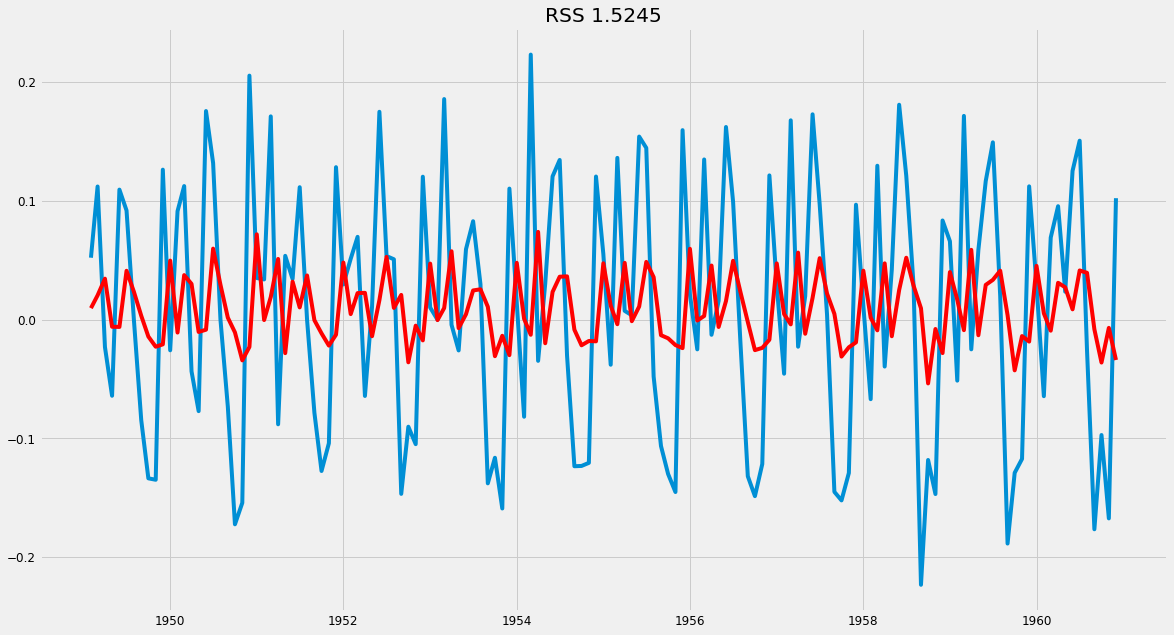

In [60]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [61]:
### in this graph its showing the resedual

### Autoregressive Moving Average (ARMA)
<ul>
    <li><b>Number of AR (Auto-Regressive) terms (p):</b> p is the parameter associated with the auto-regression aspect of the model which incoporates past values i.e lags of the dependent variable For instance if p is 5 the predictors for x(t) will be x(t-1)...x(t-5)</li>
    <li><b>Number of MA (Moving Average) terms (q):</b>q is size of the moving average part window of the model i.e lagged forcast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)...e(t-5) where e(i) is the difference between the moving average at the i-th instant and the actual value</li>
</ul>

In [62]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

model = ARMA(ts_log_diff, order=(2,1))
model_fit = model.fit(disp=False)

Text(0.5, 1.0, 'RSS: 1.1753')

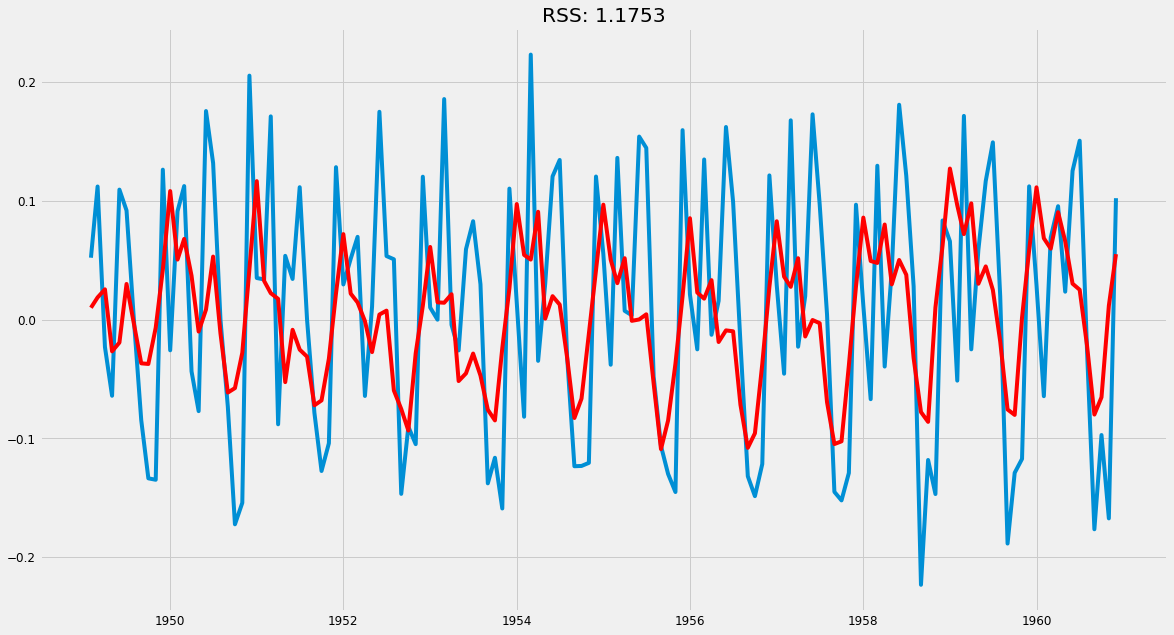

In [63]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

### Autoregressive Integrated Moving Average (ARIMA)
<p>In an ARIMA model there are3 arameters that re used to help model the major aspects of a times series:seasonality, trend and noise. These parameters are labeled p,d and q.</p>
<ul>
    <li><b>Number of AR (Auto-Regressive) terms (p):</b> p is the parameter associated with the auto- regressive aspect of the model, which incorporated past values i. lags od dependent variable. For instance if p is 5 the predictors for x(t) will be x(t-1)...x(t-5)</li>
    <li><b>Number of Differences (d):</b> d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series</li>
    <li><b>Number of MA (Moving Average) terms (q):</b>q is size of the moving average part window of the model i.e lagged forcast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)..e(t-5) where e(i) is the difference between the moving average at i-th instance and actual value</li>
</ul>    

### Observations from EDA on the time series:
<ul>
    <li>Non stationary implies at least one level of differencing (d) is required in ARIMA</li>
    <li>The next step is to select the lag values for the autoregression (AR) and movinf average (MA) parameters, p and q respectively using PACF, ACF plots</li>
</ul>
<p>Note: A problem with ARIMA is thatit does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed e.g seasonally adjusted via methods such as seasonal differencing</p>

In [64]:
ts = y.passengers - y.passengers.shift() # first order differencing previous value to current value
ts.dropna(inplace=True)

### ACF and PACF plots after differencing
<ul>
    <li>Confidence intervals are drawn as a cone</li>
    <li>by default this is set to a 95% confidence interval, suggested that correlation values outside of this code are very likely a correlation and not a stastical fluke</li>
    <li>AR(1) process -- has ACF tailing out and PACF cutting off at lag =1</li>
    <li>AR(2) process -- has ACF talling out and PACF cutting off at lag =2</li>
    <li>MA(1) process -- has ACF cut off at lag=1</li>
    <li>MA(2) process -- has ACF cut off at lag=2</li>
</ul>

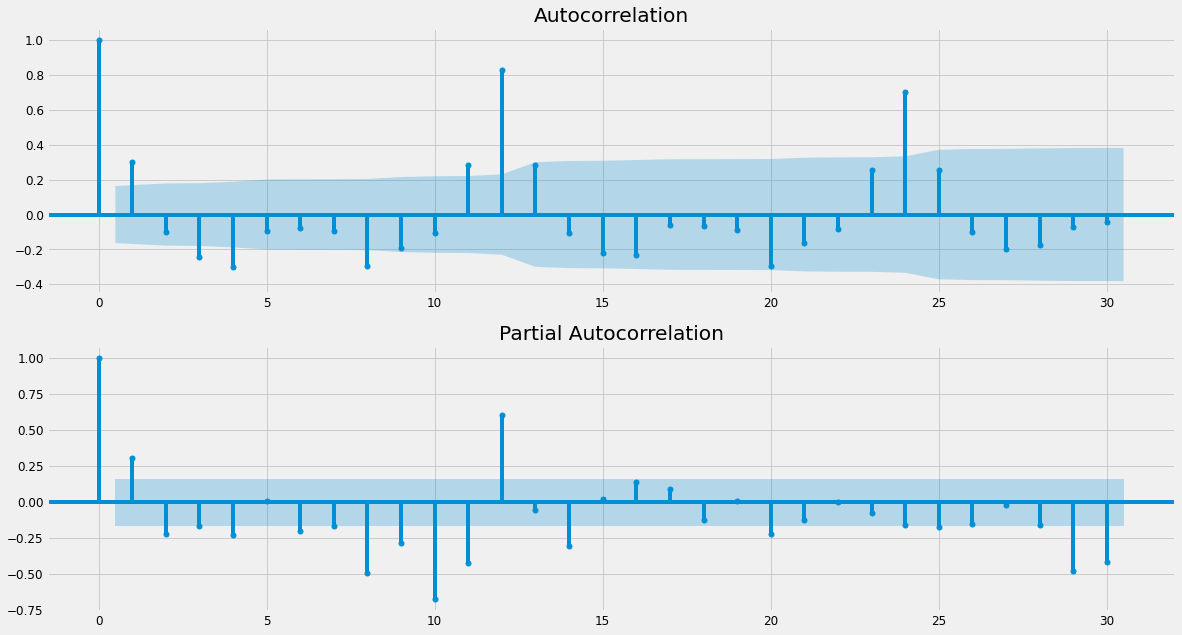

In [65]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts,ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpreting ACF plots
<table>
    <tr>
        <th>ACF Shape</th>
        <th>Indicated Model</th>
    </tr>
    <tr>
        <td>Exponential, decaying to zero</td>
        <td>Autoregressive model. Use the partial autocoorelation plot to identify the order of the autoregressive model</td>
    </tr> 
    <tr>
        <td>Altering (+)ve and (-)ve, decaying to zero Autoregressive model </td>
        <td>Use the partial autocorrelation plot help identify the order (Still you can use AR) </td>
    </tr>
    <tr>
        <td>One or more spikes , rest are essentially zero</td>
        <td>Moving average model, order identified by where plot becomes zero</td>
    </tr>
    <tr>
        <td>Decay, started after few lags</td>
        <td>Mixed autoregressive and moving average (ARIMA) model</td>
    </tr>
    <tr>
        <td>All zero or close to zero</td>
        <td>Data are essentially random (not possible to build a model)</td>
    </tr>
    <tr>
        <td>High values at fixed intervals</td>
        <td>Include seasonal autoregressive term (SERIMA MODEL)</td>
    </tr>
    <tr>
        <td>No decay to zero</td>
        <td>Series is not stationary</td>
    </tr>
</table>

<AxesSubplot:xlabel='year'>

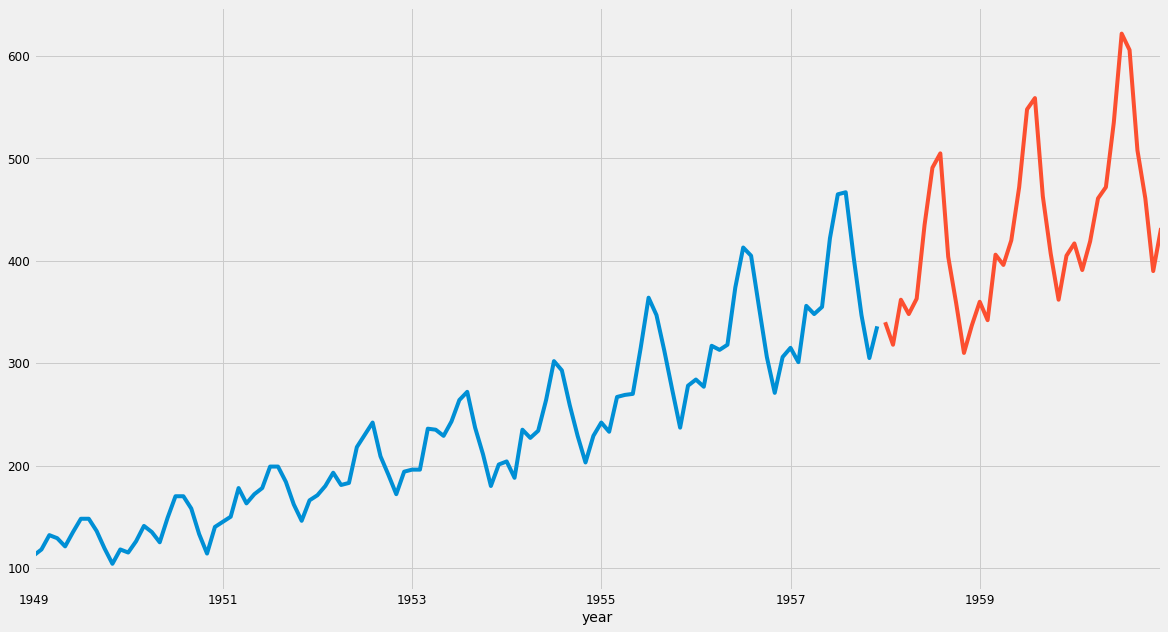

In [66]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [67]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1)) # order = 1,1,1 means ARIMA model
model_fit = model.fit(disp=1)

In [68]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Tue, 08 Jun 2021   AIC                            994.461
Time:                        07:06:02   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [69]:
start_index = valid.index.min()
end_index = valid.index.max()

#Prediction
predictions = model_fit.predict(start=start_index, end=end_index)

In [70]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE: {}'.format(rmse,mse))

RMSE: 432.626380598872, MSE: 187165.58519008005


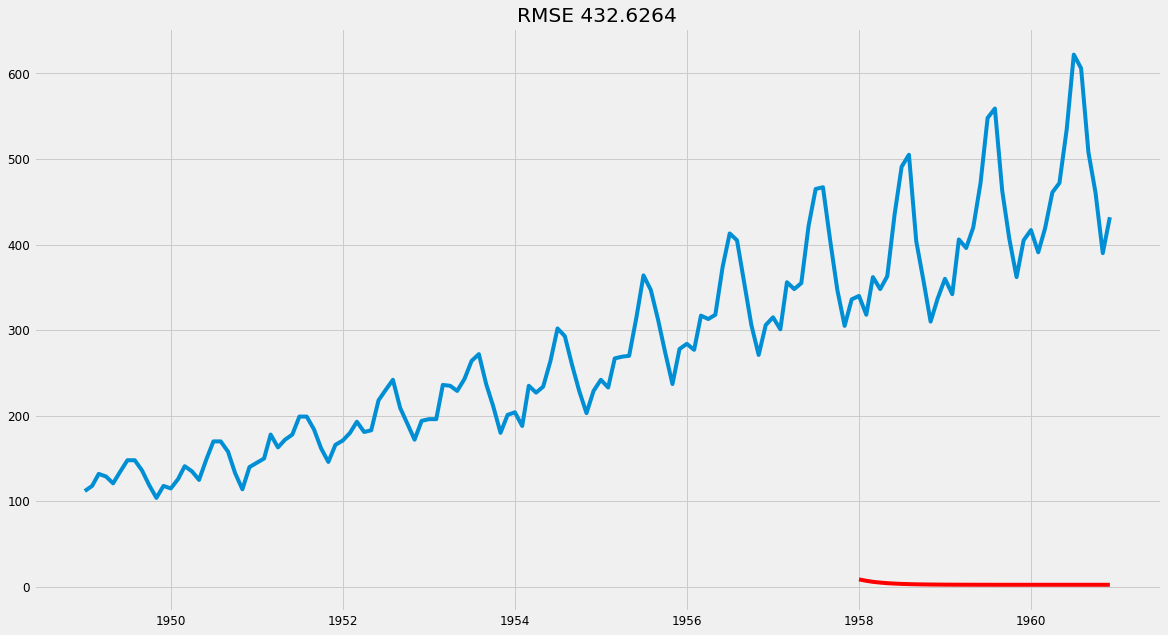

In [71]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE %.4f'%rmse)
plt.show()

#### Fitted or Predicted Value

In [72]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print(predictions_ARIMA_diff.head())

1958-01-01    8.743419
1958-02-01    7.109316
1958-03-01    5.898541
1958-04-01    5.001427
1958-05-01    4.336717
Freq: MS, dtype: float64


#### Cumulative Sum to reverse differncing:

In [73]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743419
1958-02-01    15.852735
1958-03-01    21.751276
1958-04-01    26.752703
1958-05-01    31.089420
Freq: MS, dtype: float64


#### Adding 1st month value which was previously removed while differncing

In [74]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743419
1958-02-01    355.852735
1958-03-01    361.751276
1958-04-01    366.752703
1958-05-01    371.089420
dtype: float64

#### Taking Exponent to revers Log Transform:

Text(0.5, 1.0, 'RMSE: 205.2935')

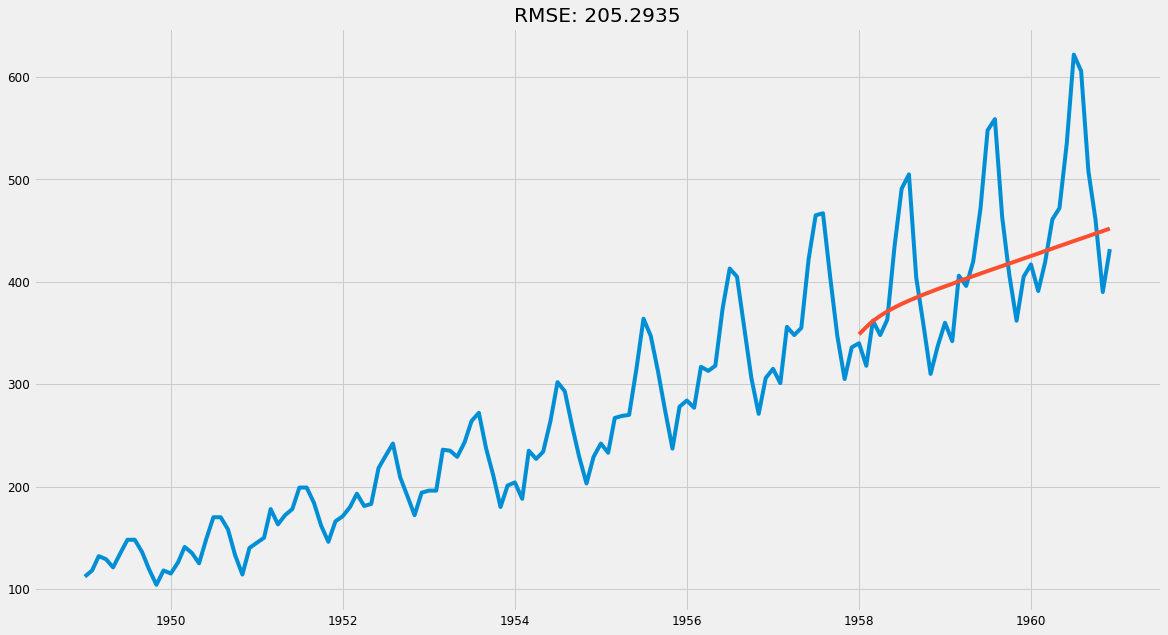

In [75]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'%np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [76]:
evaluate_forcast(y[start_index:end_index],predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.179865,52.106957,36.843691,5017.837685,0.023691,NaN,70.836697


### Auto ARIMA

In [77]:
# building the model
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', supress_warnings=True)
model.fit(train)
# ACAIC INFORMATION DATA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.28 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.755 seco

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

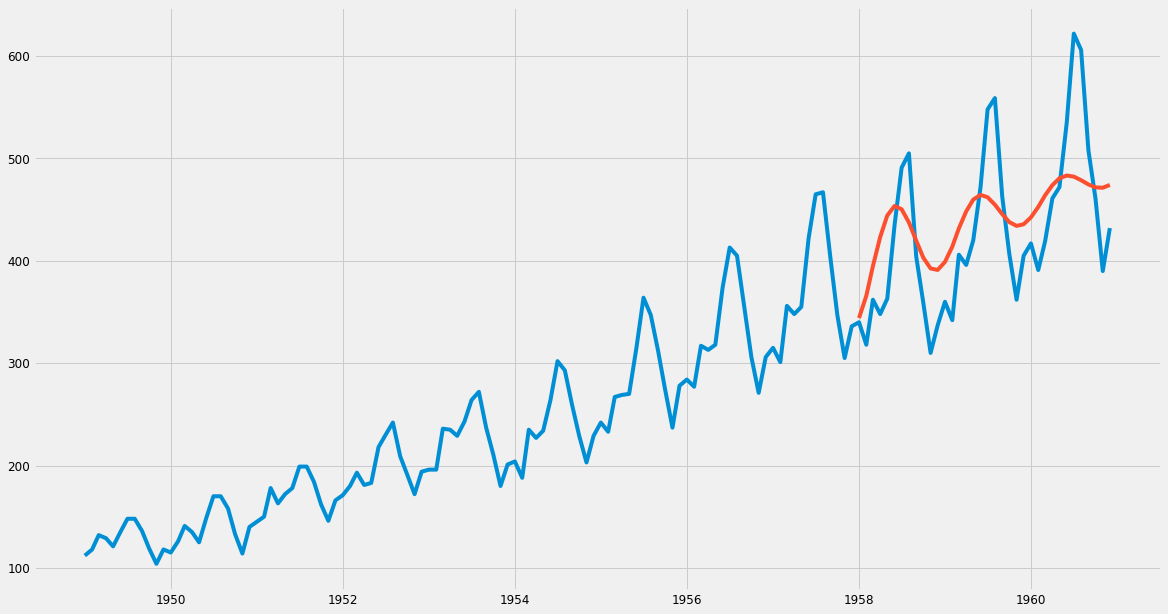

In [78]:
forcast =  model.predict(n_periods=len(valid))
forcast = pd.DataFrame(forcast, index = valid.index, columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plot.plot(valid, label='Valid')
plt.plot(forcast, label='Prediction')
plt.show()

In [79]:
evaluate_forcast(valid,forcast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.427068,49.488318,43.100281,3505.373447,0.017613,NaN,59.206194


## Seasonal Autoregressive Integrated Moving-Average (SARIMA)
<p>Seasonal Autoregressive Integrated Moving Average, Sarima or Seasonal ARIMA Is an extension of ARIMA that explicitly supports univariate time series data with seasonal component.</p>
<p>it adds three new hyperparameter to specify the autoregression (AR) differencing (I) and moving average (MA) for the seasonal component of the series as well as an additional parameter for the periof of the seasonality</p>

<p><b>Trend Element</b></p>
<p>There are three trend elements that requires configuration. They are the same as the ARIMA model specifically:</p>
<ul>
    <li>p: Trend autoregression order</li>
    <li>d: Trend difference order</li>
    <li>q: Trend moving average order</li>
</ul>  
<p><b>Second Element</b></p>
<p>There are four seasonal elements that are not part of ARIMA that must be configured they are:</p>
<ul>
    <li>P: Seasonal autoregressive order</li>
    <li>D: Seasonal difference oreder</li>
    <li>Q: Seasonal moving average order</li>
    <li>m: The No od time steps for s single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle</li>
</ul>    
<p><b>SARIMA notation:</b>SARIMA(p,d,q)(P,D,Q,m)</p>

In [91]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12)) # seasonal_order = P,D,Q,m order = p,d,q
model_fit = model.fit(disp=False)

In [92]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [93]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE: {}'.format(rmse,mse))

RMSE: 23.82373714878012, MSE: 567.5704517341659


Text(0.5, 1.0, 'RMSE: 23.8237')

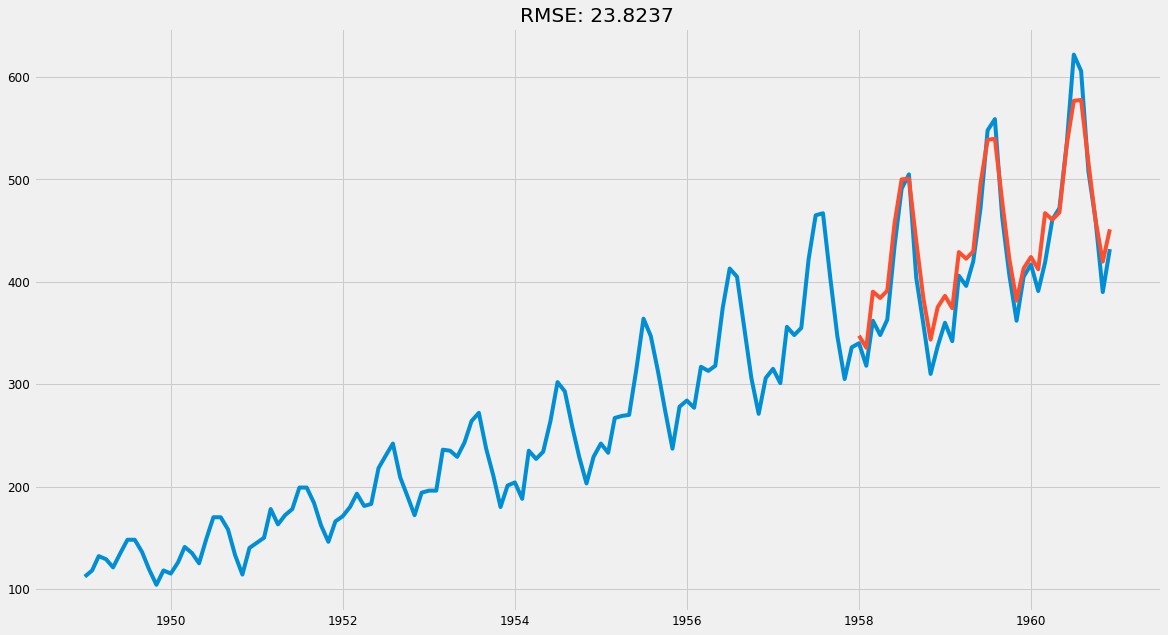

In [94]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'%rmse)

In [95]:
evaluate_forcast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.907234,20.255158,20.426993,567.570452,0.003385,NaN,23.823737


### Auto-SARIMA 

In [97]:
from pmdarima.arima import auto_arima # pyramid
model = auto_arima(train, trace=True, error_action='ignore', supress_warnings=True,seasonal=True,m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=706.671, Time=1.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.730, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=704.186, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=704.801, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=704.001, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.472, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.993, Time=0.57 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=705.691, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=705.081, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=704.376, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=707.075, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=705.875, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 3.507 seconds


In [98]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [102]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred, index = valid.index, columns=['Prediction'])

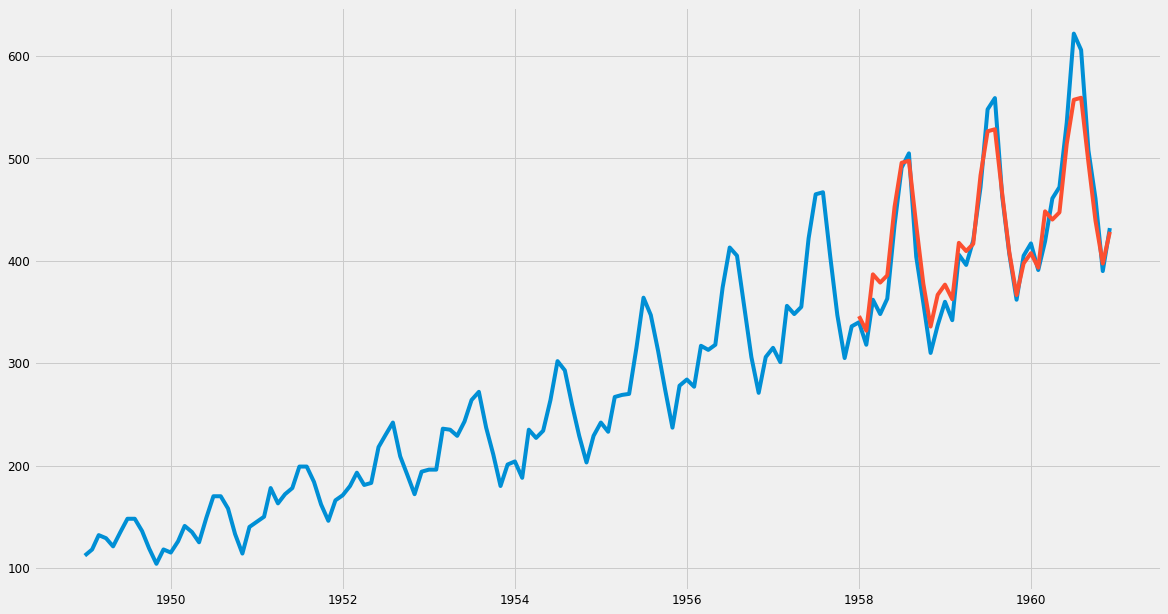

In [103]:
forcast = model.predict(n_periods=len(valid))
forcast = pd.DataFrame(forcast, index = valid.index, columns=['Prediction'])

plt.plot(y.passengers, label='Train')
plt.plot(forcast, label='Prediction')
plt.show()

### Tuned SARIMA

In [104]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [ (x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [105]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                                            train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationary=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMAX{param}x{param_seasonal}12 - AIC:{results.aic}')
            
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMAX(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1497.7366324421453
ARIMAX(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1419.5486006957087
ARIMAX(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1117.3294027063034
ARIMAX(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1084.8794536930047
ARIMAX(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1203.1225306435776
ARIMAX(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1171.0702756200183
ARIMAX(0, 0, 0)x(1, 1, 0, 6)12 - AIC:1013.3267794100082
ARIMAX(0, 0, 0)x(1, 1, 1, 6)12 - AIC:965.3387191313047
ARIMAX(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1357.7177148131827
ARIMAX(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1283.2306244923302
ARIMAX(0, 0, 1)x(0, 1, 0, 6)12 - AIC:1018.0268594450761
ARIMAX(0, 0, 1)x(0, 1, 1, 6)12 - AIC:985.863392345895
ARIMAX(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1089.6446765937885
ARIMAX(0, 0, 1)x(1, 0, 1, 6)12 - AIC:1057.2975386188118
ARIMAX(0, 0, 1)x(1, 1, 0, 6)12 - AIC:923.4829244904082
ARIMAX(0, 0, 1)x(1, 1, 1, 6)12 - AIC:888.1238487410478
ARIMAX(0, 1, 0)x(0, 0, 0, 6)12 - AIC:1001.5308118187482
ARIMAX(0, 1, 0)x(0, 0, 1, 6)12 - AIC:1003.48315357139

In [106]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 6)   Log Likelihood                -379.527
Date:                            Tue, 08 Jun 2021   AIC                            767.054
Time:                                    07:37:07   BIC                            777.515
Sample:                                01-01-1949   HQIC                           771.289
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7653      0.097      7.863      0.000       0.575       0.956
ma.L1         -1.0476      0.062    -17.007      0.000      -1.168      -0.927
ar.S.L6       -0.9714      0.022    -44.878      0.000      -1.014      -0.929
sigma2        81.4127     17.223      4.727      0.000      47.657     115.168
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 3.05
Prob(Q):                              0.36   Prob(JB):                         0.22
Heteroskedasticity (H):               1.73   Skew:                             0.42
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

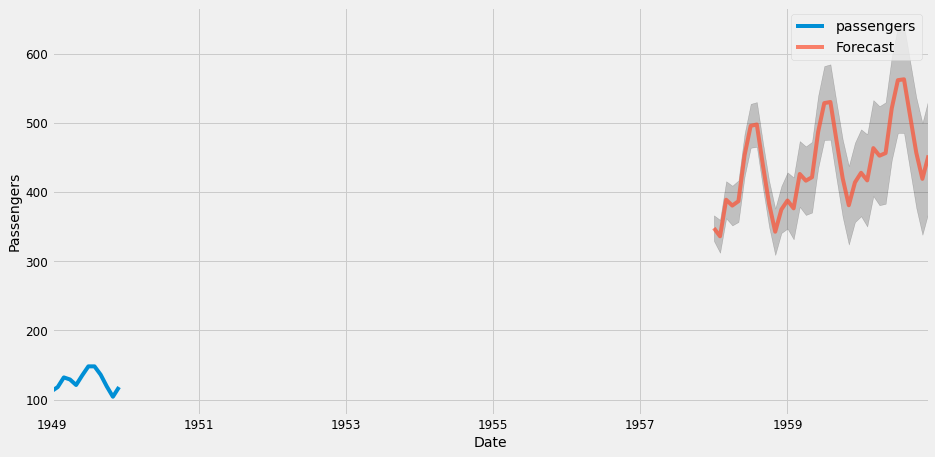

In [126]:
pred_ci = pred.conf_int()
ax = y['1949'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

<img src="https://github.com/melwinmpk/python_datascience/blob/main/ML/img/serima_forcast.png?raw=true"></img>

In [84]:
#1:34:58

In [85]:
# what are decomposed pattern in time series 
# what are trends, seasonality, Cyclic, and resedual
# what is moving Average
# what is exponential Smotheening 
# what is 

In [86]:
# former step 
# check weather the TS is stationary or not by(Rolling stats,mean, ACF, PACF, Fuller Test)
# if its not stationary use Logtransformation (Normalization) to change it into stationary then do differencing
# put the model AR,ARMA...
# after generating the predection again we retransform (exponential function) it if any transformation is applied

In [87]:
# what is Log transformation of TS


# what is differencing of TS
#     taking the subraction of the current values from the previous value
    
# what is the problem if i use the seasonality in the TS and predict in the Model ?
#     Rsquare 